In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [2]:
INPUT_PATH = "dataset_clean_tango.csv"  # si tu as un clean: "dataset_clean_rap.csv"
df = pd.read_csv(INPUT_PATH)

print("Shape:", df.shape)
df.head()


Shape: (2817, 12)


,name,artists,consolidates_genre_lists,danceability,energy,loudness,tempo,valence,speechiness,acousticness,instrumentalness,liveness
0,Vivo para Quererte - Remasterizado,['Ignacio Corsini'],"['vintage_tango', 'tango']",0.434,0.1770,-21.180,130.418,0.457,0.0512,0.994,0.021800,0.212
1,El Prisionero - Remasterizado,['Ignacio Corsini'],"['vintage_tango', 'tango']",0.321,0.0946,-27.961,169.980,0.397,0.0504,0.995,0.918000,0.104
2,Martín Fierro - Remasterizado,['Ignacio Corsini'],"['vintage_tango', 'tango']",0.548,0.0391,-23.228,75.595,0.612,0.1530,0.996,0.933000,0.148
3,El Vendaval - Remasterizado,['Ignacio Corsini'],"['vintage_tango', 'tango']",0.370,0.3720,-17.138,159.669,0.753,0.0865,0.985,0.000681,0.929
4,La Maleva - Remasterizado,['Ignacio Corsini'],"['vintage_tango', 'tango']",0.339,0.0958,-26.944,86.279,0.219,0.0530,0.994,0.969000,0.123


In [3]:
AUDIO_FEATURES_CANDIDATES = [
    "danceability", "energy", "loudness", "tempo", "valence",
    "speechiness", "acousticness", "instrumentalness", "liveness"
]

audio_features = [c for c in AUDIO_FEATURES_CANDIDATES if c in df.columns]
print("audio_features:", audio_features)


audio_features: ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']


In [4]:
X = df[audio_features].copy()

for col in audio_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")

before = len(X)
X = X.dropna()
print("Rows removed:", before - len(X))
print("Rows remaining:", len(X))

# align df
df2 = df.loc[X.index].copy()


Rows removed: 0
Rows remaining: 2817


In [5]:
stds = X.std(numeric_only=True)
constant_cols = stds[stds == 0].index.tolist()

print("constant_cols:", constant_cols)

if constant_cols:
    X = X.drop(columns=constant_cols)
    audio_features = [c for c in audio_features if c not in constant_cols]

print("final features:", audio_features)


constant_cols: []
final features: ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# sécurité numérique
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("NaN:", np.isnan(X_scaled).sum())
print("Inf:", np.isinf(X_scaled).sum())
print("X_scaled shape:", X_scaled.shape)


NaN: 0
Inf: 0
X_scaled shape: (2817, 9)


In [7]:
# Clipping des outliers pour stabiliser KMeans
X_clipped = X.copy()

for col in X_clipped.columns:
    low = X_clipped[col].quantile(0.01)
    high = X_clipped[col].quantile(0.99)
    X_clipped[col] = X_clipped[col].clip(lower=low, upper=high)

X_clipped.describe()


,danceability,energy,loudness,tempo,valence,speechiness,acousticness,instrumentalness,liveness
count,2817.000000,2817.000000,2817.000000,2817.000000,2817.000000,2817.000000,2817.000000,2817.000000,2817.000000
mean,0.623556,0.281093,-13.440142,119.550115,0.705783,0.111786,0.971333,0.446954,0.199563
std,0.145765,0.144466,5.359750,26.061915,0.175552,0.083541,0.055243,0.377328,0.140158
min,0.271320,0.034212,-26.960200,62.442840,0.180000,0.033600,0.647000,0.000000,0.051760
25%,0.515000,0.172000,-16.974000,112.099000,0.600000,0.056300,0.978000,0.026200,0.111000
50%,0.640000,0.259000,-12.846000,118.989000,0.730000,0.080900,0.992000,0.433000,0.141000
75%,0.734000,0.366000,-9.184000,127.626000,0.842000,0.135000,0.995000,0.854000,0.250000
max,0.885000,0.688720,-4.452560,203.765760,0.966000,0.429680,0.996000,0.970000,0.783880


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clipped)

X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("NaN:", np.isnan(X_scaled).sum())
print("Inf:", np.isinf(X_scaled).sum())
print("shape:", X_scaled.shape)


NaN: 0
Inf: 0
shape: (2817, 9)


In [9]:
from sklearn.utils import resample

ks = range(2, 8)
inertias = []
silhouettes = []

X_sil = X_scaled
if X_scaled.shape[0] > 5000:
    X_sil = resample(X_scaled, n_samples=5000, random_state=42)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_sil, labels[:len(X_sil)])
    silhouettes.append(sil)
    print(f"k={k} | inertia={km.inertia_:.2f} | silhouette={sil:.4f}")


/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sa

k=2 | inertia=21282.84 | silhouette=0.1758
k=3 | inertia=18652.05 | silhouette=0.1635


/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeW

k=4 | inertia=16811.15 | silhouette=0.1574
k=5 | inertia=15504.95 | silhouette=0.1588
k=6 | inertia=14391.43 | silhouette=0.1589
k=7 | inertia=13434.24 | silhouette=0.1590


/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeW

In [10]:
print("X columns:", list(X.columns))
print("dtypes:\n", X.dtypes)


X columns: ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
dtypes:
 danceability        float64
energy              float64
loudness            float64
tempo               float64
valence             float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
dtype: object


In [11]:
best_k = 4  # choix empirique justifié

kmeans = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init=10,
    algorithm="lloyd"
)

df2["cluster"] = kmeans.fit_predict(X_scaled)
df2["cluster"].value_counts().sort_index()


/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sa

cluster
0    1131
1     186
2     653
3     847
Name: count, dtype: int64

/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/vixa/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


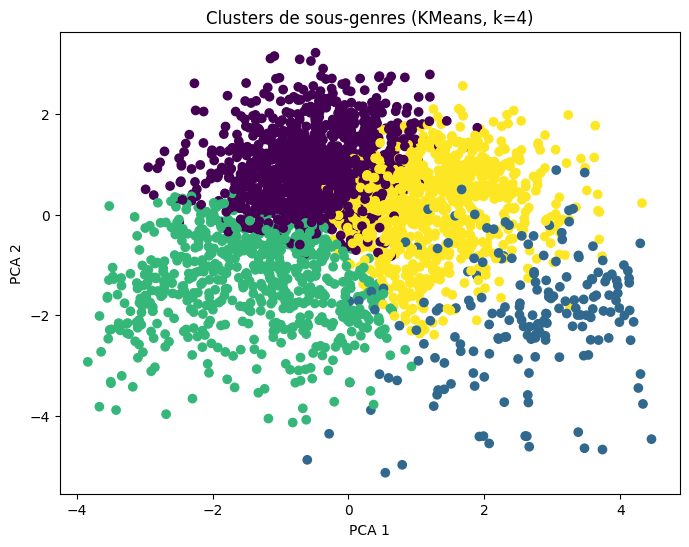

In [12]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df2["pca1"] = X_pca[:, 0]
df2["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df2["pca1"], df2["pca2"], c=df2["cluster"])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters de sous-genres (KMeans, k=4)")
plt.show()


In [13]:
audio_features = ["danceability", "energy", "loudness", "tempo", "valence",
                  "speechiness", "acousticness", "instrumentalness", "liveness"]

cluster_means = df2.groupby("cluster")[audio_features].mean().round(3)
cluster_means
#plus qu'a merge le main
#test

,danceability,energy,loudness,tempo,valence,speechiness,acousticness,instrumentalness,liveness
cluster,,,,,,,,,
0,0.732,0.209,-14.480,118.580,0.764,0.154,0.987,0.397,0.149
1,0.513,0.490,-9.135,119.136,0.560,0.083,0.762,0.179,0.253
2,0.484,0.193,-18.586,106.218,0.543,0.085,0.987,0.669,0.183
3,0.608,0.401,-9.076,131.039,0.784,0.086,0.976,0.402,0.270
